# General Note
In order to guide you through the homework, we put "...COMPLETE HERE..." as placeholder for you to complete the homework.

In [1]:
%matplotlib inline


# Classifying Names with a Character-Level RNN

We will biuld and train a character-level *Recurrent Neural
Network* (*RNN*) to classify words.

A character-level RNN reads words as a series of characters -
it outputs a prediction and hidden state at each step, and feeds the
previous hidden state into each next step. We take the final prediction
to be the output, that represents which class the word belongs to.

We want to predict the Language class to which belongs the Surnames.

## Preparing the Data

We will create a dictionary of lists of names per language,
``{language: [names ...]}``.


In [2]:
!git clone https://github.com/sarafrr/pytorch-tutorial-nlp-public.git

Cloning into 'pytorch-tutorial-nlp-public'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 100 (delta 39), reused 81 (delta 23), pack-reused 0
Receiving objects: 100% (100/100), 1.55 MiB | 11.48 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
# general import

import os
from glob import glob
from io import open
import string
import numpy as np
import random
import torch
import torch.nn as nn

In [4]:
def getFiles(path):
  return glob(path)

file_list = getFiles('./data/Names/*.txt')
print(file_list[:2])

['./data/Names/Scottish.txt', './data/Names/German.txt']


In [5]:
!rm -r pytorch-tutorial-nlp-public/

In [6]:
# read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

print(readLines(file_list[0]))
print(readLines(file_list[1]))

['Smith', 'Brown', 'Wilson', 'Campbell', 'Stewart', 'Thomson', 'Robertson', 'Anderson', 'Macdonald', 'Scott', 'Reid', 'Murray', 'Taylor', 'Clark', 'Ross', 'Watson', 'Morrison', 'Paterson', 'Young', 'Mitchell', 'Walker', 'Fraser', 'Miller', 'Mcdonald', 'Gray', 'Henderson', 'Hamilton', 'Johnston', 'Duncan', 'Graham', 'Ferguson', 'Kerr', 'Davidson', 'Bell', 'Cameron', 'Kelly', 'Martin', 'Hunter', 'Allan', 'Mackenzie', 'Grant', 'Simpson', 'Mackay', 'Mclean', 'Macleod', 'Black', 'Russell', 'Marshall', 'Wallace', 'Gibson', 'Kennedy', 'Gordon', 'Burns', 'Sutherland', 'Stevenson', 'Munro', 'Milne', 'Watt', 'Murphy', 'Craig', 'Wood', 'Muir', 'Wright', 'Mckenzie', 'Ritchie', 'Johnstone', 'Sinclair', 'White', 'Mcmillan', 'Williamson', 'Dickson', 'Hughes', 'Cunningham', 'Mckay', 'Bruce', 'Millar', 'Crawford', 'Mcintosh', 'Douglas', 'Docherty', 'King', 'Jones', 'Boyle', 'Fleming', 'Mcgregor', 'Aitken', 'Christie', 'Shaw', 'Maclean', 'Jamieson', 'Mcintyre', 'Hay', 'Lindsay', 'Alexander', 'Ramsay', '

In [7]:
# category_words is a dict with the key as the language
# and the value a list with all the possible names in the specific language
category_words = {}
all_categories = []
alphabet = set()

for filename in file_list:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    for word in lines:
      alphabet |= set(word)
    category_words[category] = lines

# letter to index
l_to_i = dict(zip(alphabet, range(len(alphabet))))
print(category_words)
n_categories = len(all_categories)
print(f'N. of languages: {n_categories}')
print(l_to_i)
n_letters = len(l_to_i)
print(f'The alphabet has {n_letters} letters')

{'Scottish': ['Smith', 'Brown', 'Wilson', 'Campbell', 'Stewart', 'Thomson', 'Robertson', 'Anderson', 'Macdonald', 'Scott', 'Reid', 'Murray', 'Taylor', 'Clark', 'Ross', 'Watson', 'Morrison', 'Paterson', 'Young', 'Mitchell', 'Walker', 'Fraser', 'Miller', 'Mcdonald', 'Gray', 'Henderson', 'Hamilton', 'Johnston', 'Duncan', 'Graham', 'Ferguson', 'Kerr', 'Davidson', 'Bell', 'Cameron', 'Kelly', 'Martin', 'Hunter', 'Allan', 'Mackenzie', 'Grant', 'Simpson', 'Mackay', 'Mclean', 'Macleod', 'Black', 'Russell', 'Marshall', 'Wallace', 'Gibson', 'Kennedy', 'Gordon', 'Burns', 'Sutherland', 'Stevenson', 'Munro', 'Milne', 'Watt', 'Murphy', 'Craig', 'Wood', 'Muir', 'Wright', 'Mckenzie', 'Ritchie', 'Johnstone', 'Sinclair', 'White', 'Mcmillan', 'Williamson', 'Dickson', 'Hughes', 'Cunningham', 'Mckay', 'Bruce', 'Millar', 'Crawford', 'Mcintosh', 'Douglas', 'Docherty', 'King', 'Jones', 'Boyle', 'Fleming', 'Mcgregor', 'Aitken', 'Christie', 'Shaw', 'Maclean', 'Jamieson', 'Mcintyre', 'Hay', 'Lindsay', 'Alexander'

In [8]:
# this is all the necessary code to set the seed
def set_seed(seed : int = 123):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [9]:
set_seed()

### Turning Names into Tensors

As always, we have to convert textual data into tensors.

To represent a single letter, we use a "one-hot vector" of size
``(1 x n_letters)``, where 1 is the respective index of the letter it is representing.

To make a word we combine a bunch of those representations into a 2D matrix
``(word_length x 1 x n_letters)``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here, for the sake of simplicity.




# Question 1
Create the auxiliary function to process the data to have the input suitable for `nn.Embedding`. This is because one of the following questions will be to try not to use one-hot-encoding representation, but use the embedding layer instead.

In [10]:
def letterToIndex(letter):
  '''
  Returns the index of a letter in the alphabet
  '''
  return l_to_i[letter]

def wordToOneHotTensor(word):
  '''
  Returns the word in zero-hot encoding
  '''
  tensor = torch.zeros(len(word), 1, n_letters).long()
  for idx, let in enumerate(word):
      tensor[idx][0][letterToIndex(let)] = 1
  return tensor

def wordToEmbedding(word):
  indexes = [letterToIndex(letter) for letter in word]
  return torch.tensor(indexes, dtype=torch.long)

tmp = 'Aarle'

print(f'N. of letters {len(alphabet)}')
print(f'Length of the word {len(tmp)}\n')
print(wordToOneHotTensor(tmp).size())
print(wordToOneHotTensor(tmp))
print('\n')
print(wordToEmbedding(tmp).size())
print(wordToEmbedding(tmp))

N. of letters 87
Length of the word 5

torch.Size([5, 1, 87])
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0

# Question 2
Implement the Vanilla RNN considering a batch size of dimension 1 (the simplest case).

## Creating the Network

Here, we are going to create RNNs with one only layer for the sake of simplicity. However, these models can be easily expanded to the more general case of having more layers.  

The Vanilla RNN is just 2 linear layers which operate on an input and hidden state.




In [11]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [12]:
class RNNEmb(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNNEmb, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.embedding = nn.Embedding(input_size, hidden_size)

    self.e2h = nn.Linear(hidden_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    embedded = self.embedding(input)
    combined = torch.cat((torch.unsqueeze(embedded, 0), hidden), 1)
    hidden = self.e2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

# Question 3
Implement an LSTM cell considering a batch size of dimension 1 (the simplest case).

In [52]:
class LSTM(torch.nn.Module):


    def __init__(self, input_length, hidden_length, type_layer):
        super(LSTM, self).__init__()

        self.input_length = input_length
        self.hidden_length = hidden_length
        self.type_layer = type_layer

        # forget gate components
        self.linear_forget_w1 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_forget_r1 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_forget = nn.Sigmoid()

        # input gate components
        self.linear_gate_w2 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r2 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_gate = nn.Sigmoid()

        # cell memory components
        self.linear_gate_w3 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r3 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.activation_gate = nn.Tanh()

        # out gate components
        self.linear_gate_w4 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r4 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_hidden_out = nn.Sigmoid()

        self.activation_final = nn.Tanh()
        self.log_softmax = nn.LogSoftmax(dim=1)


    def forget(self, x, h):
        x = self.linear_forget_w1(x)
        h = self.linear_forget_r1(h)
        return self.sigmoid_forget(x + h)


    def input_gate(self, x, h):
        # Equation 1. input gate
        x_temp = self.linear_gate_w2(x)
        h_temp = self.linear_gate_r2(h)
        i = self.sigmoid_gate(x_temp + h_temp)
        return i


    def cell_memory_gate(self, i, f, x, h, c_prev):
        x = self.linear_gate_w3(x)
        h = self.linear_gate_r3(h)

        # new information part that will be injected in the new context
        k = self.activation_gate(x + h)
        g = k * i

        # forget old context/cell info
        c = f * c_prev
        # learn new context/cell info
        c_next = g + c
        return c_next


    def out_gate(self, x, h):
        x = self.linear_gate_w4(x)
        h = self.linear_gate_r4(h)
        return self.sigmoid_hidden_out(x + h)


    def forward(self, x, tuple_in):
        x = x.to(torch.float32)

        (h, c_prev) = tuple_in
        # Equation 1. input gate
        #print(x.dtype, h.dtype)
        i = self.input_gate(x, h)

        # Equation 2. forget gate
        f = self.forget(x, h)

        # Equation 3. updating the cell memory
        c_next = self.cell_memory_gate(i, f, x, h, c_prev)

        # Equation 4. calculate the main output gate
        o = self.out_gate(x, h)

        # Equation 5. produce next hidden output
        h_next = o * self.activation_final(c_next)

        return self.log_softmax(o), (h_next, c_next)
        #return o, (h_next, c_next)

        #return h_next, (h_next, c_next)
        #return self.log_softmax(h_next), (h_next, c_next)



    def initHidden(self):
        return (torch.zeros(1, self.hidden_length).to(torch.float32), torch.zeros(1, self.hidden_length).to(torch.float32))

## Training
Preparing for Training
----------------------

The output of the network is a likelihood of each category. Use ``Tensor.topk`` to get the index
of the greatest value:




In [14]:
def categoryFromOutput(output):
    top_val, top_idx = output.topk(1)
    # print(top_val)
    # print(top_idx)
    category_idx = top_idx[0].item()
    return all_categories[category_idx], category_idx

We will also want a quick way to get a training example (a name and its
language):




In [15]:
print(all_categories)

['Scottish', 'German', 'Arabic', 'Polish', 'Japanese', 'English', 'Spanish', 'Irish', 'Chinese', 'Russian', 'Greek', 'French', 'Dutch', 'Czech', 'Portuguese', 'Italian', 'Korean', 'Vietnamese']


# Related to Question 1
In order to use the embeddings in place of one-hot-encoded representation, you should modify also the function `randomChoice()` in the following snippet of code to have the correct input data.

In [16]:
import random

def randomChoice(l):
  '''
  Returns a random integer given the list of languages
  '''
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(model):
    category = randomChoice(all_categories)
    word = randomChoice(category_words[category])
    # create a long tensor with the index of the language
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    if model == 'embeds': word_tensor = wordToEmbedding(word)
    else: word_tensor = wordToOneHotTensor(word)

    return category, word, category_tensor, word_tensor

for ty in ['embeds', 'linear']:
  for i in range(4):
    category, word, category_tensor, word_tensor = randomTrainingExample(ty)
    print('category =', category, '\n word =', word, '\n category_tensor =', category_tensor, '\n word_tensor =', word_tensor, '\n len word_tensor =', word_tensor.size())
    print('\n')

category = German 
 word = Holzmann 
 category_tensor = tensor([1]) 
 word_tensor = tensor([17, 42, 54, 64, 22, 67, 81, 81]) 
 len word_tensor = torch.Size([8])


category = Arabic 
 word = Amari 
 category_tensor = tensor([2]) 
 word_tensor = tensor([25, 22, 67,  5, 19]) 
 len word_tensor = torch.Size([5])


category = Czech 
 word = Miksatkova 
 category_tensor = tensor([13]) 
 word_tensor = tensor([70, 19, 63, 72, 67, 84, 63, 42, 66, 67]) 
 len word_tensor = torch.Size([10])


category = Polish 
 word = Brzezicki 
 category_tensor = tensor([3]) 
 word_tensor = tensor([45,  5, 64, 34, 64, 19, 78, 63, 19]) 
 len word_tensor = torch.Size([9])


category = Dutch 
 word = Sneijders 
 category_tensor = tensor([12]) 
 word_tensor = tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
          0, 0, 0, 0, 0, 

### Training the Network
 In the following change the initialisation with the model you want to use.




In [17]:
n_hidden = 128
criterion = nn.NLLLoss()

In [18]:
rnn_embeds = RNNEmb(n_letters, n_hidden, n_categories, 'embeds')

In [19]:
rnn = RNN(n_letters, n_hidden, n_categories, 'linear')

In [53]:
lstm = LSTM(n_letters, n_hidden, 'linear')

Each loop of training will:

1. Create input and target tensors
2. Read each letter in and keep the hidden state for next letter
3. Compare final output to target
4. Back-propagate
5. Return the output and loss




# Question 3
After having tryied the learning rate which is proposed in the script, `0.005`, use the learning rate equal to `1`. What is happening? Can you explaing why?

What is the quickest way to get rid of the problem? Modify the code trying to implement a possible solution.

What is the other problem this kind of network has? And what are the possible solutions?

In [54]:
from torch import optim


def train(category_tensor, word_tensor, model, optimizer):
    # If you set this too high, it might explode. If too low, it might not learn
    #learning_rate = 0.005
    #optimizer = optim.SGD(model.parameters(), lr = lr)
    #optimizer = optim.Adam(model.parameters(), lr = learning_rate)


    #h_lstm, h_rnn = None, None
    #h = None

    #if model.__class__.__name__ == "LSTM": h_lstm = model.initHidden()
    #else: h_rnn = model.initHidden()
    h = model.initHidden()

    optimizer.zero_grad()
    # iterate over the word for all the letters in the word
    for i in range(word_tensor.size(0)):
      # modify the following with the correct implementation depending on the
      # network you are using


        #output, h_lstm = model(word_tensor[i], h_lstm)
      #else:
        #output, h_rnn = model(word_tensor[i], h_rnn)
      output, h = model(word_tensor[i], h)
      if model.__class__.__name__ == "LSTM": output = model.log_softmax(output)

    #print(output.size(), category_tensor.size())
    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()
    return output, loss.item()

The ``train`` function returns the output and loss we can print what are its predictions and also to keep track of the loss.
We can choose how many examples print these outputs thanks to ``print_every``.




In [55]:
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

def run_training(model, optimizer):
  n_iters = 100000
  print_every = 5000
  plot_every = 1000

  # keep track of losses for plotting
  current_loss = 0
  all_losses = []



  start = time.time()

  for iter in range(1, n_iters + 1):
      category, word, category_tensor, word_tensor = randomTrainingExample(model.type_layer)
      #print(type(category), type(word), category_tensor[0].dtype, word_tensor[0].dtype)

      output, loss = train(category_tensor, word_tensor, model, optimizer)
      current_loss += loss

      if iter % print_every == 0:
          category_pred, category_idx = categoryFromOutput(output)
          correct = 'OK' if category_pred == category else 'NO (%s)' % category
          print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, word, category_pred, correct))

      # add the current loss to the list of losses
      if iter % plot_every == 0:
          all_losses.append(current_loss / plot_every)
          current_loss = 0

  return all_losses

In [23]:
lr = 0.005
optimizer_rnn = optim.SGD(rnn.parameters(), lr = lr)
#optimizer_rnn = optim.Adam(rnn.parameters(), lr = lr)

rnn_losses = run_training(rnn, optimizer_rnn)

5000 5% (0m 6s) 2.1380 Ambrosi / Italian OK
10000 10% (0m 14s) 6.7813 Gravari / Japanese NO (Greek)
15000 15% (0m 21s) 2.4734 Pfeifer / German NO (Czech)
20000 20% (0m 27s) 0.2930 Guerra / Portuguese OK
25000 25% (0m 35s) 1.0316 Choe / Korean OK
30000 30% (0m 41s) 2.5668 Capper / German NO (English)
35000 35% (0m 50s) 1.9061 Tikal / Russian NO (Czech)
40000 40% (0m 56s) 2.3709 Doljs / Dutch NO (Czech)
45000 45% (1m 3s) 0.4880 Ryom / Korean OK
50000 50% (1m 11s) 2.8435 Maciomhair / French NO (Irish)
55000 55% (1m 17s) 3.9862 Straub / Arabic NO (German)
60000 60% (1m 24s) 0.2728 Siew / Chinese OK
65000 65% (1m 31s) 0.9828 Close / Greek OK
70000 70% (1m 38s) 0.2907 Xiao / Chinese OK
75000 75% (1m 45s) 1.5591 Fleming / Scottish OK
80000 80% (1m 52s) 1.5489 San nicolas / Portuguese NO (Spanish)
85000 85% (1m 59s) 4.1852 Clark / Czech NO (Irish)
90000 90% (2m 6s) 2.1000 Rizzo / Portuguese NO (Italian)
95000 95% (2m 13s) 4.0364 Gravari / Italian NO (Greek)
100000 100% (2m 20s) 0.0935 Geng / C

In [24]:
lr = 0.005
optimizer_rnn_embeds = optim.SGD(rnn_embeds.parameters(), lr = lr)
#optimizer_rnn_embeds = optim.Adam(rnn_embeds.parameters(), lr = lr)

rnn_embeds_losses = run_training(rnn_embeds, optimizer_rnn_embeds)

5000 5% (0m 8s) 1.3157 Aylward / English OK
10000 10% (0m 17s) 10.8582 Kokkali / Japanese NO (Greek)
15000 15% (0m 25s) 0.2941 Itagaki / Japanese OK
20000 20% (0m 33s) 2.6161 Papke / Czech NO (German)
25000 25% (0m 42s) 5.9048 Houk / Korean NO (German)
30000 30% (0m 50s) 0.0735 Smolák / Polish OK
35000 35% (0m 58s) 0.0345 Zhabrev / Russian OK
40000 40% (1m 7s) 2.0029 Laurenz / Spanish NO (German)
45000 45% (1m 16s) 0.1754 Chweh / Korean OK
50000 50% (1m 24s) 0.5357 Menendez / Spanish OK
55000 55% (1m 33s) 0.0078 O'Kelly / Irish OK
60000 60% (1m 41s) 0.1266 Stolarz / Polish OK
65000 65% (1m 49s) 0.0066 Jernokleev / Russian OK
70000 70% (1m 58s) 0.0351 Jakovlev / Russian OK
75000 75% (2m 7s) 0.0475 La / Vietnamese OK
80000 80% (2m 15s) 0.0185 Manoukarakis / Greek OK
85000 85% (2m 24s) 1.3604 Tolkien / German OK
90000 90% (2m 33s) 2.6705 Adlersflügel / Czech NO (German)
95000 95% (2m 41s) 1.1783 Cermak / Polish NO (Czech)
100000 100% (2m 49s) 2.1098 Gauk / Arabic NO (Chinese)


In [56]:
lr = 0.005
#optimizer_lstm = optim.SGD(lstm.parameters(), lr = lr)
optimizer_lstm = optim.Adam(lstm.parameters(), lr = lr)

lstm_losses = run_training(lstm, optimizer_lstm)

5000 5% (0m 34s) 4.0537 Holguín / Korean NO (Spanish)
10000 10% (1m 11s) 3.9820 Halabi / Polish NO (Arabic)
15000 15% (1m 47s) 3.9648 Hudilainen / Dutch NO (Russian)
20000 20% (2m 22s) 3.9237 Thuy / Chinese NO (Vietnamese)
25000 25% (2m 58s) 3.9204 Yue / Chinese OK
30000 30% (3m 34s) 3.9658 Castro / Portuguese NO (Spanish)
35000 35% (4m 11s) 3.9245 Tableriou / Greek OK
40000 40% (4m 47s) 3.9111 Ho / Korean OK
45000 45% (5m 23s) 3.9327 Pasternack / Czech NO (Polish)
50000 50% (5m 59s) 3.9168 Ichiro / Italian NO (Japanese)
55000 55% (6m 34s) 3.9415 Lyons / English OK
60000 60% (7m 9s) 3.9958 Lefévre / English NO (French)
65000 65% (7m 45s) 3.9306 Sokolof / Polish OK
70000 70% (8m 22s) 3.8926 Thai / Chinese NO (Vietnamese)
75000 75% (8m 58s) 3.9635 Mcguire / English NO (Irish)
80000 80% (9m 34s) 3.8867 Jimenez / Spanish OK
85000 85% (10m 11s) 3.9403 Gil / Chinese NO (Korean)
90000 90% (10m 47s) 3.9453 Hanraets / Spanish NO (Dutch)
95000 95% (11m 24s) 3.9533 Semick / Polish NO (Czech)
1000

# Question 4
Use the LSTM to make the predictions, feel free to modify the optimizer and/or the learning rate to see the training loss decreasing. Pay attention that the LSTM returns a number of components different by the ones that are returned by a Vanilla RNN, thus modify the code accordingly (especially the `train()` function).


# Question 5
Modify the network of the Vanilla RNN to use an embedding layer and not using the one-hot-encoding representation and train again the network. Verify that the network has been trained considering the training loss. It has to be decreasing.

### See that the training loss is decreasing

Plotting the historical loss from ``all_losses`` shows the network
learning:




In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def print_losses(all_losses, title):
  plt.figure()
  plt.plot(all_losses)
  plt.xlabel('Iterations')
  plt.ylabel('NLLLoss')
  plt.title(title)
  plt.show()

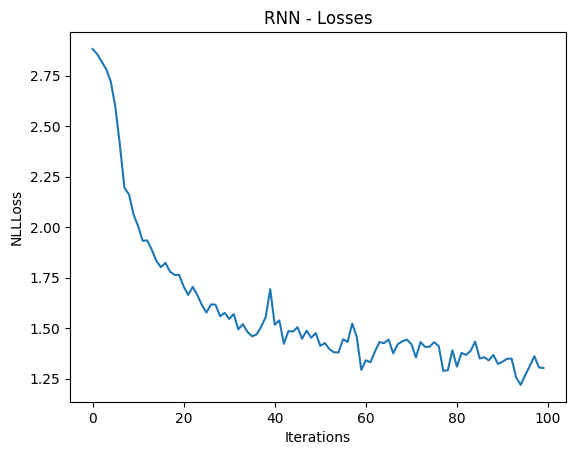

In [27]:
print_losses(rnn_losses, 'RNN - Losses')

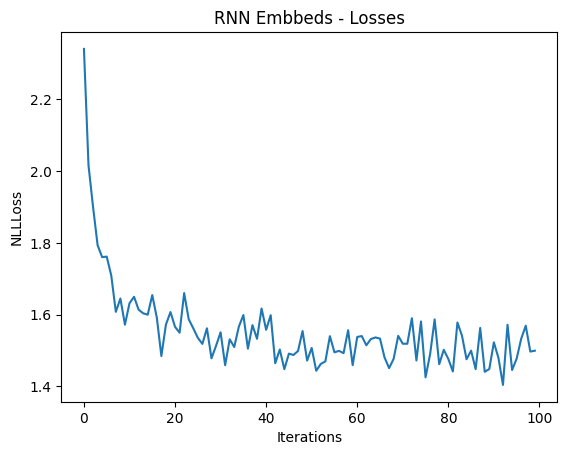

In [28]:
print_losses(rnn_embeds_losses, 'RNN Embbeds - Losses')

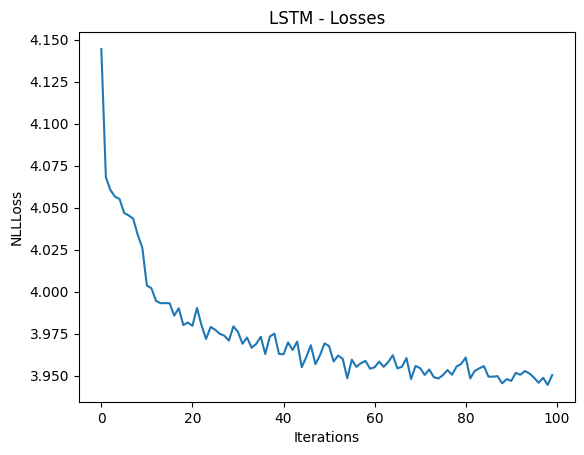

In [57]:
print_losses(lstm_losses, 'LSTM - Losses')

In [ ]:
# Just return an output given a line
def evaluate(line_tensor, model):
    hidden = model.initHidden()#None
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

def create_confusion_matrix(model):
  # Keep track of correct guesses in a confusion matrix
  confusion = torch.zeros(n_categories, n_categories)
  n_confusion = 10000

  # Go through a bunch of examples and record which are correctly guessed
  for i in range(n_confusion):
      category, line, category_tensor, line_tensor = randomTrainingExample(model.type_layer)
      output = evaluate(line_tensor, model)
      guess, guess_i = categoryFromOutput(output)
      category_i = all_categories.index(category)
      confusion[category_i][guess_i] += 1

  # Normalize by dividing every row by its sum
  for i in range(n_categories):
      confusion[i] = confusion[i] / confusion[i].sum()

  # Set up plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)

  # Set up axes
  ax.set_xticklabels([''] + all_categories, rotation=90)
  ax.set_yticklabels([''] + all_categories)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # sphinx_gallery_thumbnail_number = 2
  plt.show()

<ipython-input-40-ee740ff3592a>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-40-ee740ff3592a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


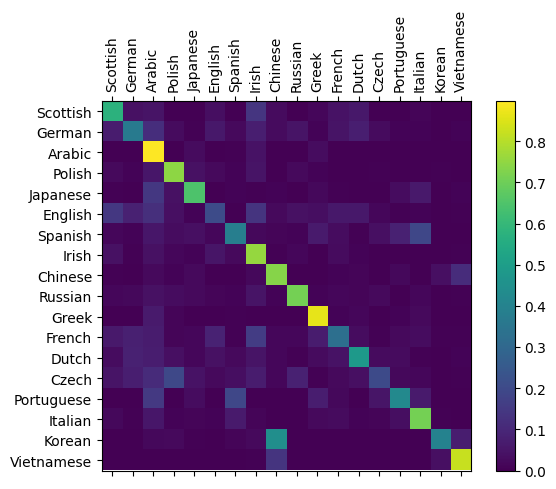

In [41]:
create_confusion_matrix(rnn)

<ipython-input-40-ee740ff3592a>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-40-ee740ff3592a>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


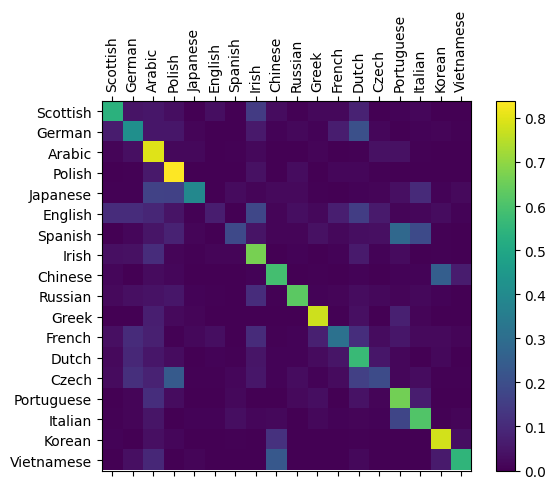

In [42]:
create_confusion_matrix(rnn_embeds)

In [ ]:
create_confusion_matrix(lstm)

# Question 6
Make a function to extract the embedding and visualise in the 2D space with the color w.r.t. the Language class. Feel free to modify the `get_embeddings()` function to return what you think could be useful for the plotting. Let's use also the cosine similarity between the embeddings to see if the embedding has a sense.

In [44]:
def getTrainingSample(word):
    # create a long tensor with the index of the language
    word_tensor = wordToOneHotTensor(word)
    return word_tensor

def get_embedding(mapping: dict, model):
  ''' COMPLETE_HERE '''
  return hiddens, words, languages




In [45]:
from sklearn.manifold import TSNE
viz_words = 100
indices = np.random.choice(hiddens.shape[0], viz_words)

NameError: ignored

In [ ]:

colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'white', 'gray', 'orange', 'purple', 'brown', 'pink', 'teal', 'olive', 'indigo', 'violet', 'gold']

tsne = TSNE()
#embed_tsne = tsne.fit_transform(hiddens.squeeze()[:,:])
embed_tsne = tsne.fit_transform(hiddens.squeeze()[indices,:])

fig, ax = plt.subplots(figsize=(12, 12))
for i, val in enumerate(indices):
    key_index = list(category_words.keys()).index(languages[val])

    plt.scatter(*embed_tsne[i, :], color=colors[key_index])
    plt.annotate(words[val]+' ('+languages[val]+')', (embed_tsne[i, 0], embed_tsne[i, 1]), alpha=0.7)
